In [1]:
import os
import json
import time
import pickle
import requests
import time
import warnings
import numpy as np
import pandas as pd
from pandas import plotting
import matplotlib.pyplot as plt

# Ignore warnings from scikit-learn to make this notebook a bit nicer
warnings.simplefilter('ignore')

# Models may be implemented as pipelines
from sklearn.pipeline import Pipeline

# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot

# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)


from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
#Pipeline toolset
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

#Model toolset
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances


In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [4]:
df['Revenue'] = df['Revenue'].astype(str)
df['Weekend'] = df['Weekend'].astype(str)

In [ ]:
df.describe()

In [5]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [6]:
X = df.iloc[:,:-1]
y = df["Revenue"]


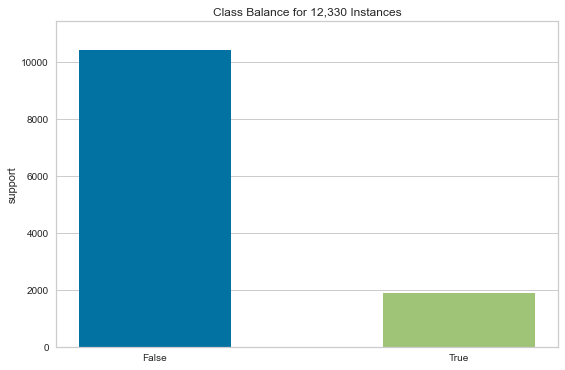

<AxesSubplot:title={'center':'Class Balance for 12,330 Instances'}, ylabel='support'>

In [7]:

#from yellowbrick.datasets import load_game
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=["False", "True"])

visualizer.fit(y)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [8]:
from sklearn.utils import resample
seed = 123


#Separate majority and minority classes
majority = df[df.Revenue=='False']
minority = df[df.Revenue=='True']

# Downsample majority class
majority_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

# Combine minority class with downsampled majority class
df = pd.concat([majority_downsampled, minority])

# Display new class counts
df['Revenue'].value_counts()

True     1908
False    1908
Name: Revenue, dtype: int64

In [9]:
X = df.iloc[:,:-1]
y = df["Revenue"]


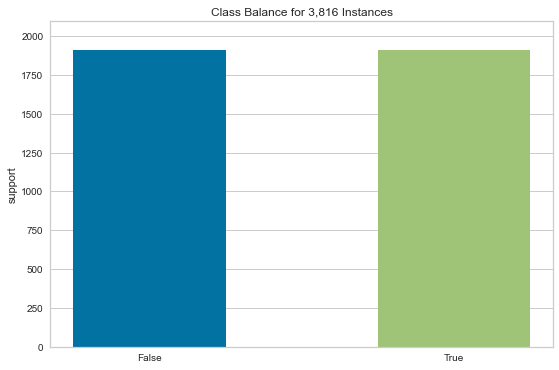

<AxesSubplot:title={'center':'Class Balance for 3,816 Instances'}, ylabel='support'>

In [10]:

#from yellowbrick.datasets import load_game
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=["False", "True"])

visualizer.fit(y)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [11]:

from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3052, 17) (3052,)
(764, 17) (764,)


In [13]:

categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)


models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]


def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [14]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def visualize_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['False', 'True'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

F1 SCORE SVC: 0.8641039523551705


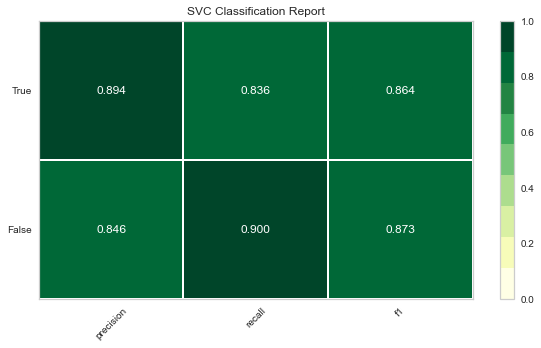

F1 SCORE NuSVC: 0.8512683578104139


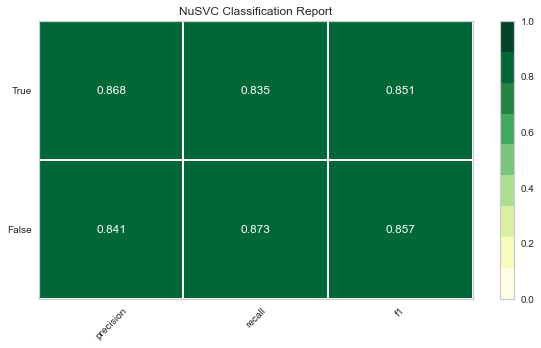

F1 SCORE LinearSVC: 0.7984021304926763


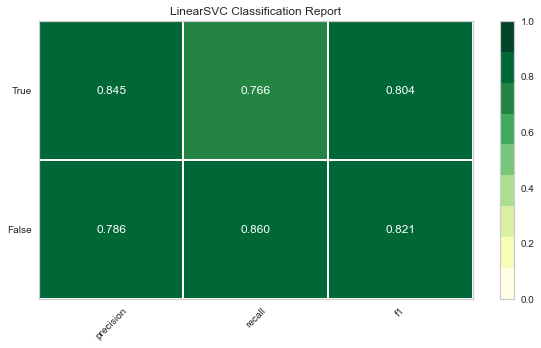

F1 SCORE SGDClassifier: 0.7047959487637773


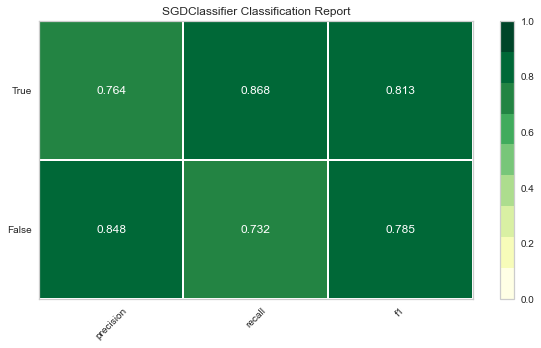

F1 SCORE KNeighborsClassifier: 0.8323699421965318


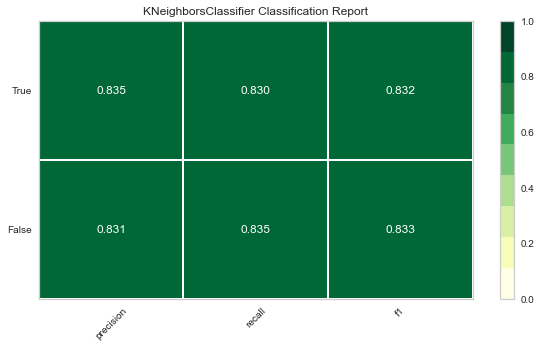

F1 SCORE LogisticRegression: 0.8162700608743774


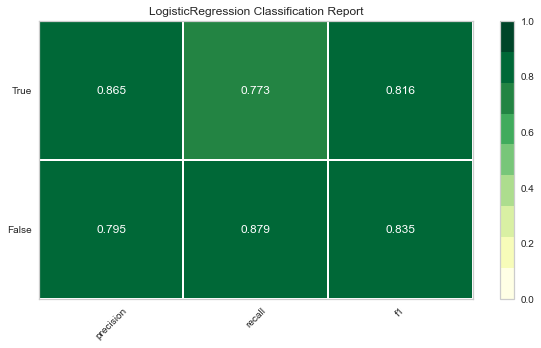

F1 SCORE LogisticRegressionCV: 0.7864983534577387


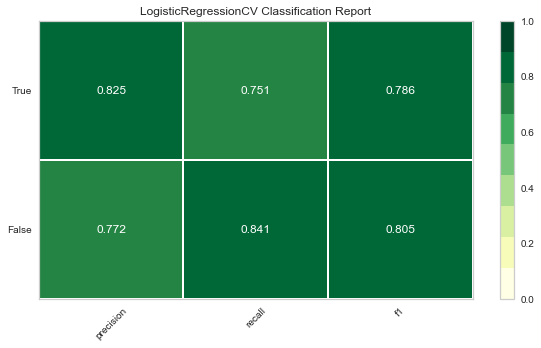

F1 SCORE BaggingClassifier: 0.9897070467141725


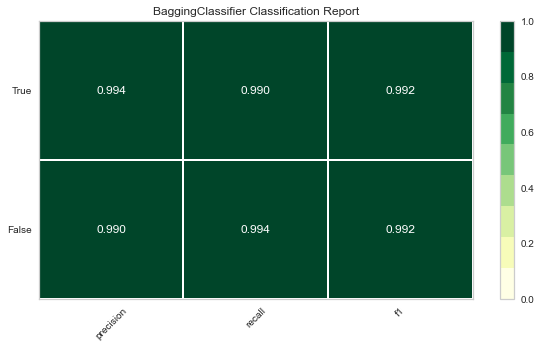

F1 SCORE ExtraTreesClassifier: 1.0


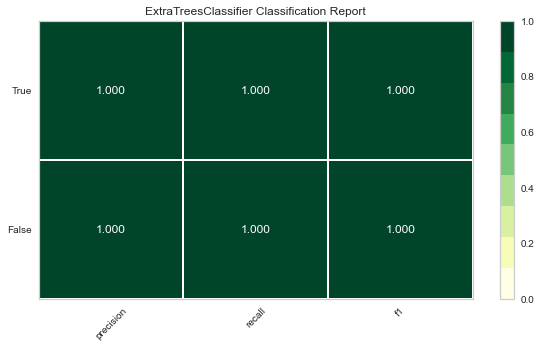

F1 SCORE RandomForestClassifier: 1.0


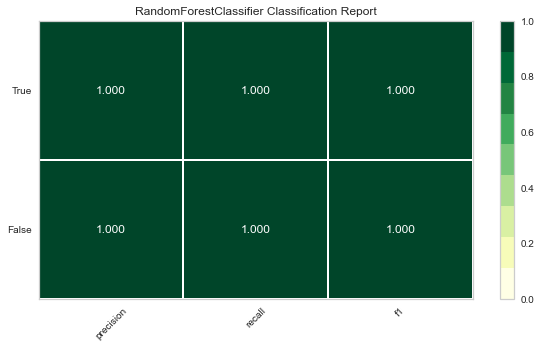

In [15]:
for model in models:
    score_model(X, y, model)
    visualize_model(X, y, model)

F1 SCORE SVC: 0.8686868686868686


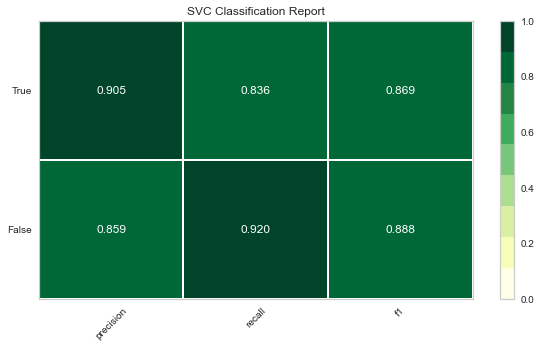

F1 SCORE NuSVC: 0.8595261928595261


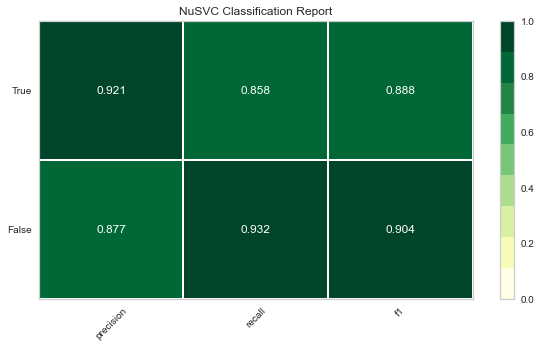

F1 SCORE LinearSVC: 0.8061394728061395


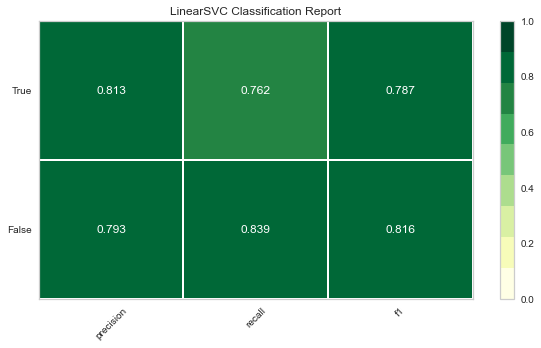

F1 SCORE SGDClassifier: 0.7353698932646301


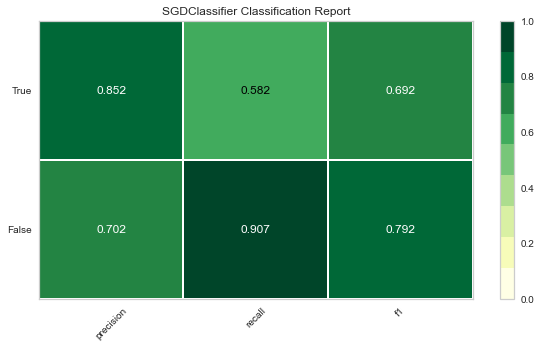

F1 SCORE KNeighborsClassifier: 0.8351719662556782


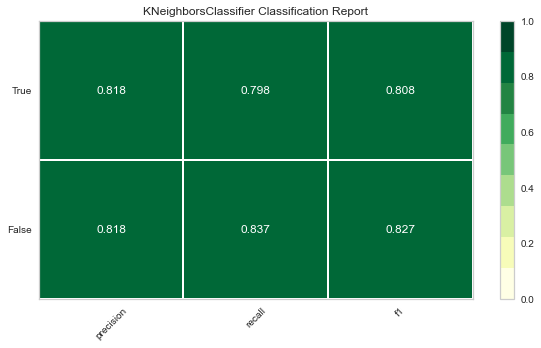

F1 SCORE LogisticRegression: 0.8211829436038515


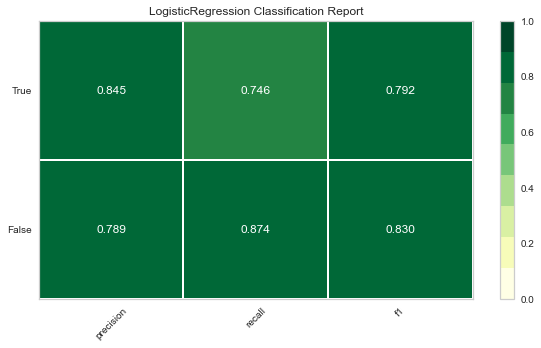

F1 SCORE LogisticRegressionCV: 0.8212194281777471


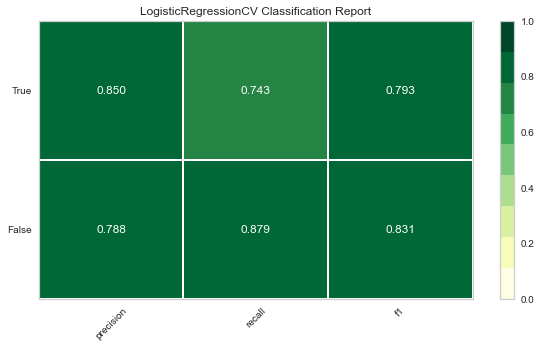

F1 SCORE BaggingClassifier: 0.9928292046936115


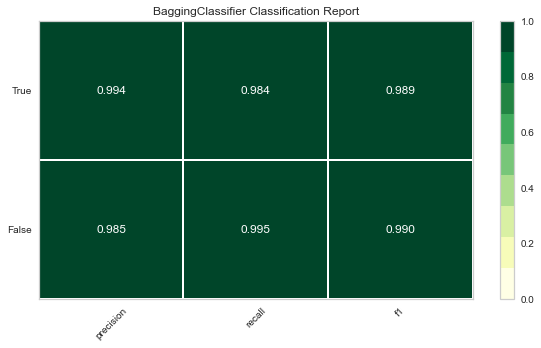

F1 SCORE ExtraTreesClassifier: 1.0


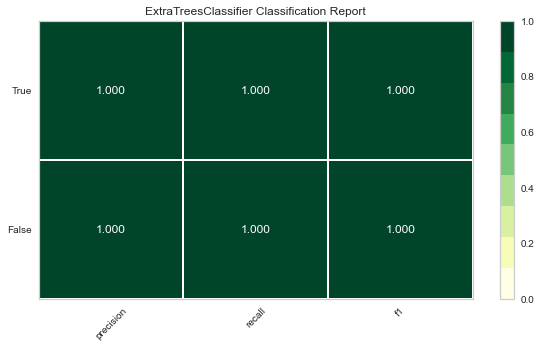

F1 SCORE RandomForestClassifier: 1.0


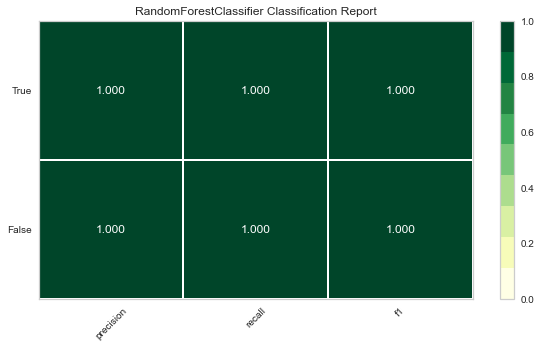

In [16]:
for model in models:
    score_model(X_train, y_train, model)
    visualize_model(X_test, y_test, model)